# House price prediction with XGBoost

### Data Science Assigment 2 <br>
***Submitted by***<br>
**Vishnu Prasad J S**

THe below code is taken from the Kaggle repository <https://www.kaggle.com/rtatman/machine-learning-with-xgboost-in-r>

## Xgboost

XGBoost is one of the most powerful ML algorithm from tree ensemble group. XGboost based on the decision tree answer search and it`s using GradientBoosting framework.
To have better understanding of XGBoost, let's remember basics: 

*There are 2 main types of decision tree ensemble:*

1. Bagging
2. Boosting

In Bagging we combine predictors from multiple-decision trees through a majority voting mechanism.

In Boosting we build models sequentially by minimizing the error from previous models while increasing (or boosting) influence of high performance models. 



A spesial case of Boosting in which the error is minimized is Gradient Descent Algorithm (GDA-optimization algorithm)-in case of recruitment process-
the least qualified candidates are eliminated as early as possible.

The same with minimizing errors from different trees.
If you are able to minimize errors (here with GDA) - this tree-candidate is promissing and worth to continue work with it.

XGBoost is optimized GradientBoosting algorithm through parallel processing, tree-pruning,handling missing values and regularization to avoid overfitting/bias.


### XGBoost requirements and properties:
 1. XGBoost is working with numerical vectors, so all object data should be transformed (as option- One-Hot_Encoder:output- new columns with feature name and binary 0/1 value - availabiity of given feature)
 2. XGBoost doesn`t suffer from colinear features, however it is a good practice to drop them.

# 2. Data Processing

In [1]:
import pandas as pd

%matplotlib inline
import seaborn as sns
print("Setup Complete")

# from sklearn.preprocessing import Imputer
# from sklearn_pandas import CategoricalImputer
#pip install sklearn-pandas

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn import ensemble

from sklearn.model_selection import KFold,cross_val_score

import matplotlib.pyplot as plt
import numpy as np

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

Setup Complete


In [2]:
#read data
df_train = pd.read_csv('./Data/train.csv',na_values='nan')
df_test = pd.read_csv('./Data/test.csv',na_values='nan')
print("Train size:",df_train.shape)
print("Test size:",df_test.shape)

#Save the 'Id' column
train_ID =df_train['Id']
test_ID =df_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)
print ("Size of train data after dropping Id: {}" .format(df_train.shape))
print ("Size of test data after dropping Id: {}" .format(df_test.shape))



Train size: (1460, 81)
Test size: (1459, 80)
Size of train data after dropping Id: (1460, 80)
Size of test data after dropping Id: (1459, 79)


In [3]:
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [4]:
df_train_num = df_train.select_dtypes(exclude=['object'])
df_train_num.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

# 2.1 Outliars drop and Normality check

In [5]:
#Deleting outliers
train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

Import to check data dictribution in the columns. It is good to have *normal distribution.***** The normal (or Gaussian) distribution is one particular kind of a bell shaped curve. It is unimodal (there is one peak"), symmetric (that is you can flip it around its mid point) and its mean, median and mode are all equal. ML algothitms are working better on the data with normal distribution, in this case we can more accurately predict. The lesser its value differs from the mean value of the random variable, the higher is its probability.

There are different tools to check data normality (quantile check,Shapiro-Wilk’s W test, Kolmogorov-Smirnov test). Let's use shapiro test and check p-value. If defined p-val >0.05, then data has Normal Distribution.



In [6]:

from scipy.stats import shapiro
stat, p = shapiro(df_train['SalePrice'])
print('Value for SalePrice column statistics=%.3f, p=%.3f' % (stat, p))

Value for SalePrice column statistics=0.870, p=0.000


p-val for SalePrice is less than 0.05, distrubution not Normal.Some Tranfrormation is required

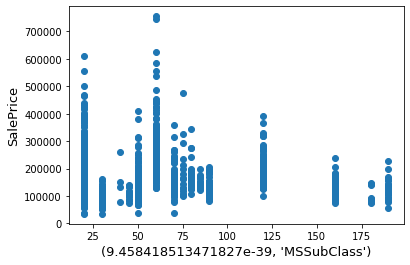

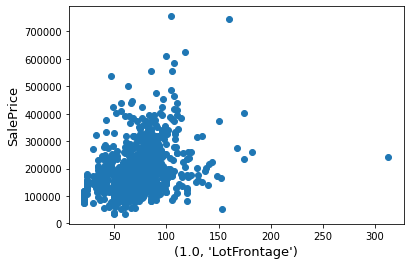

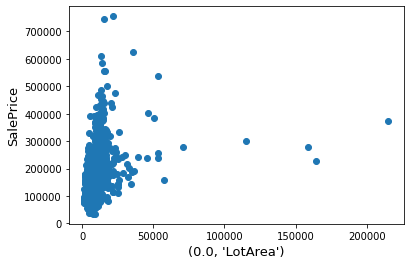

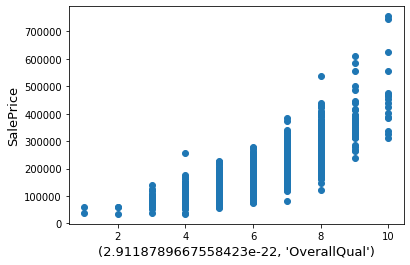

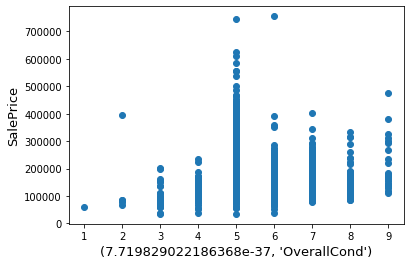

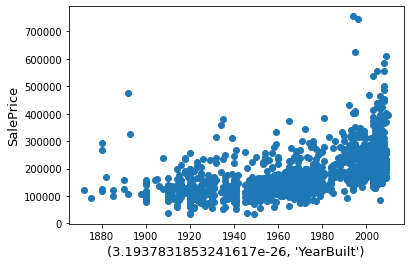

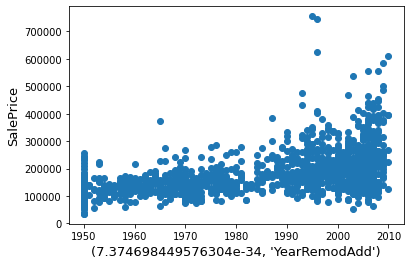

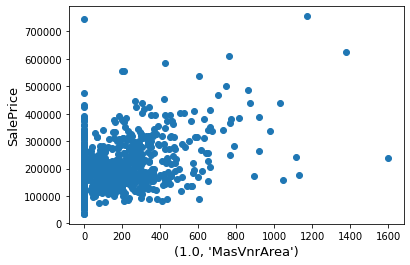

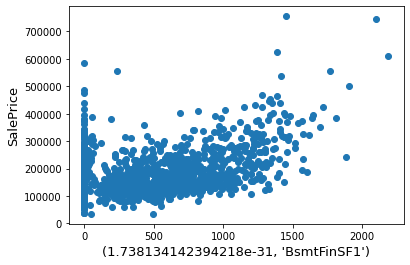

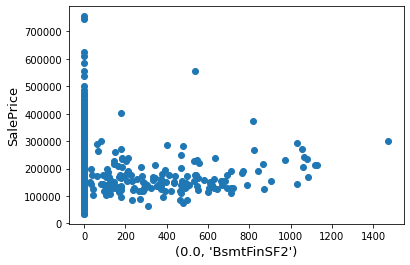

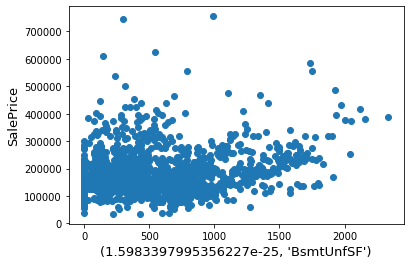

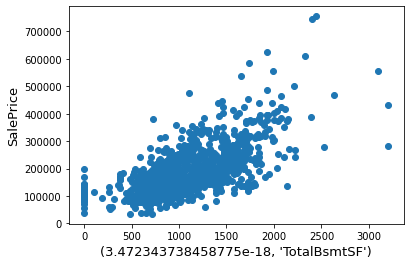

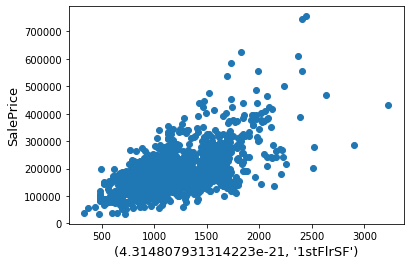

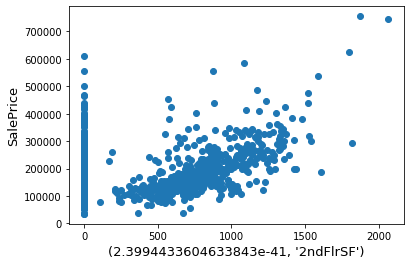

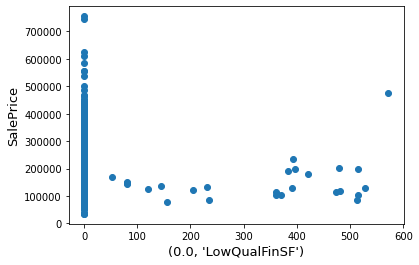

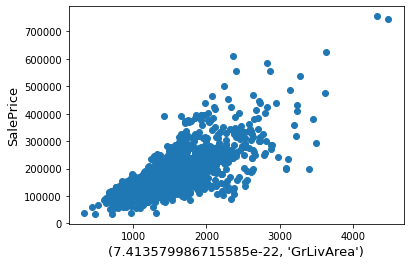

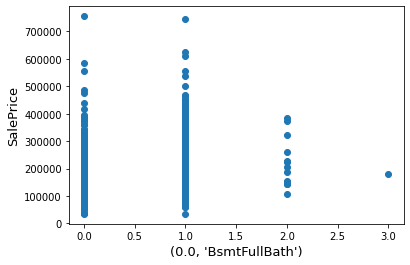

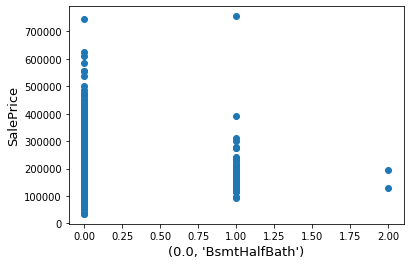

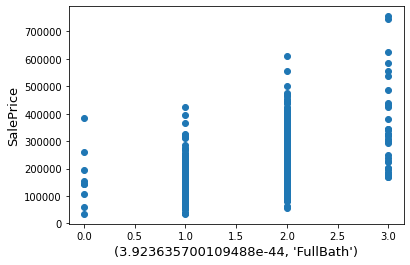

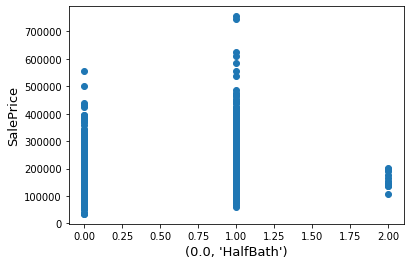

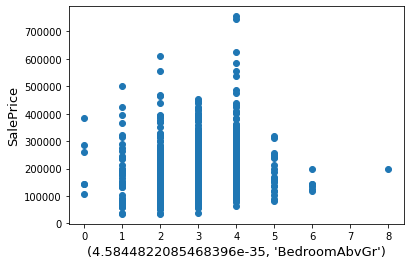

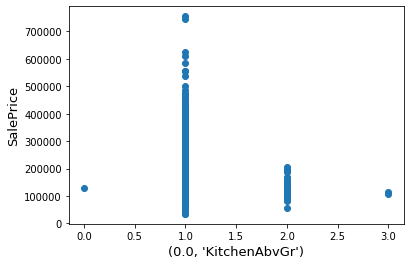

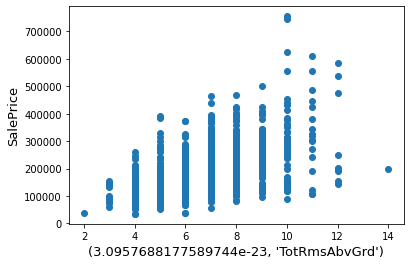

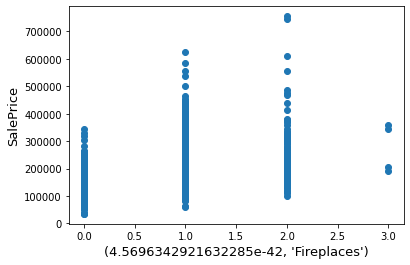

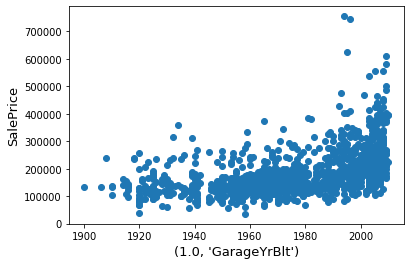

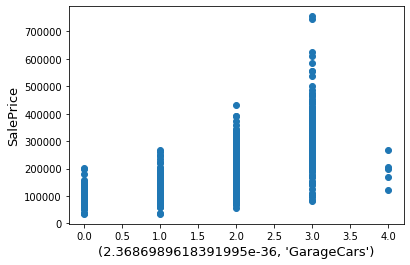

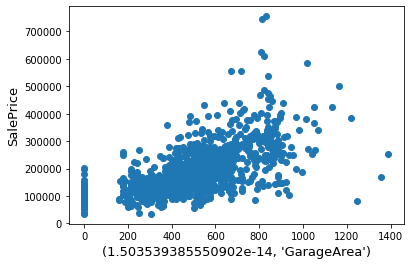

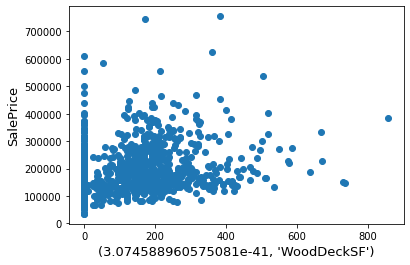

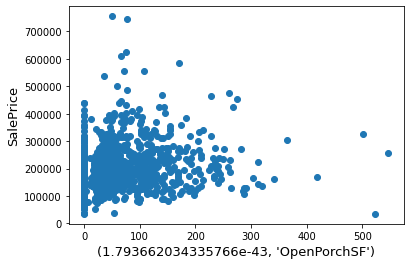

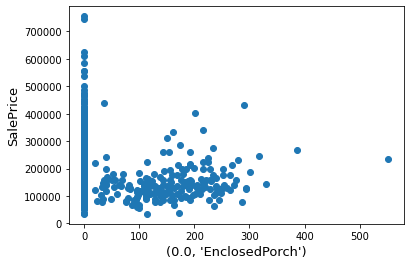

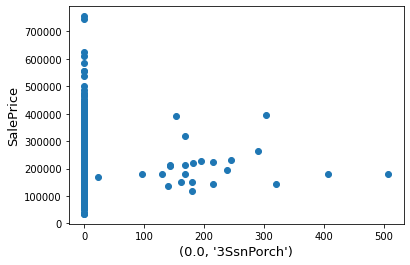

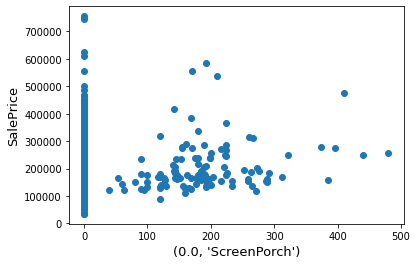

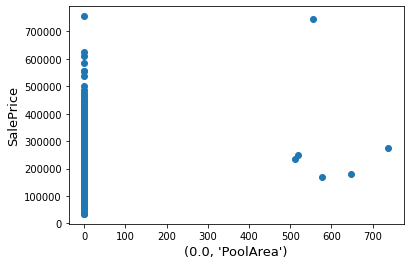

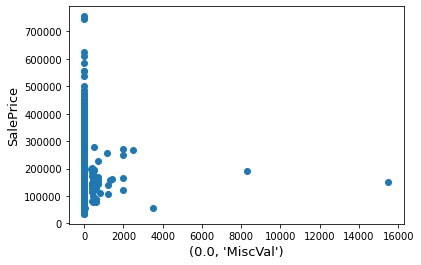

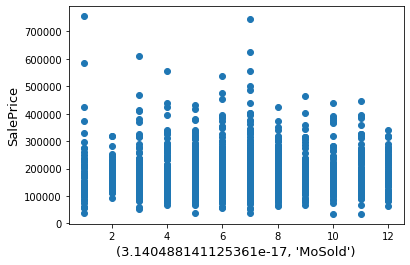

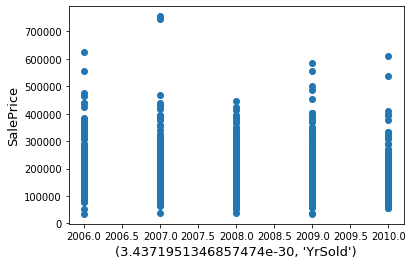

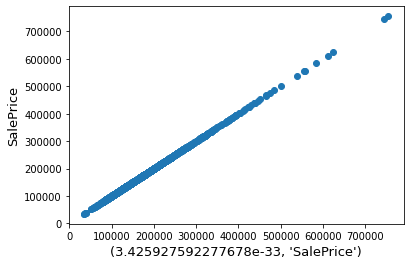

In [7]:
# Check normality for features
for col in df_train_num.columns:
    fig, ax = plt.subplots()
    stat, p = shapiro(train[col])
    ax.scatter(x =train[col], y = train['SalePrice'])
    plt.ylabel('SalePrice', fontsize=13)
    plt.xlabel((p,col), fontsize=13)
    plt.show()

In [8]:
p_df=[]
for col in df_train_num.columns:
    stat, p = shapiro(df_train[col])
    p_df.append(p)
    
#>0.05 means are normally distributed
# Only 3 columns have normal distribution
p_df_=pd.DataFrame(p_df,df_train_num.columns).sort_values(by=0,ascending=True)
p_df_=p_df_.loc[p_df_[0]>0.05]
p_df_

,0
GarageYrBlt,1.0
MasVnrArea,1.0
LotFrontage,1.0


## 2.2 Check Correlation
Main idea of correlation - quantify the strengh of relation between values. Max correlation val = abs(1) only for numeric columns

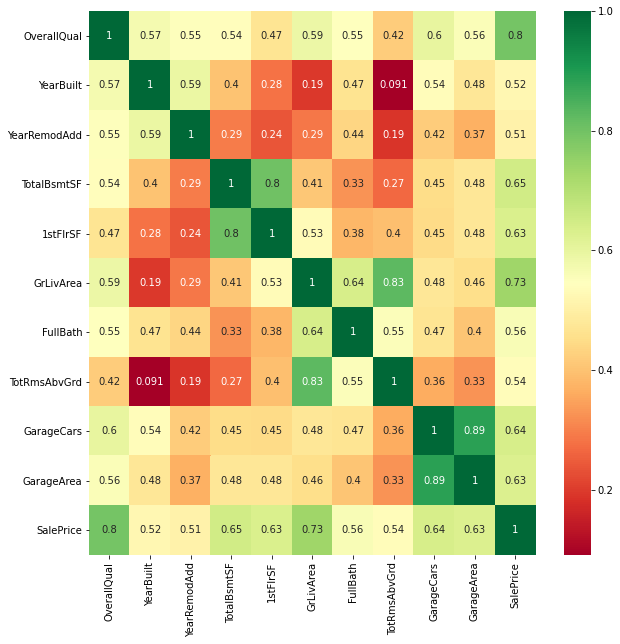

In [9]:
# most correlated features to SalePrice
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [10]:

train[top_corr_features].columns

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
       'SalePrice'],
      dtype='object')

Here we see some colinear features, like 'YearBuilt'/'YearRemodAdd', or 'GarageCars'/ 'GarageArea',

# 2.3 Together Train/Test

In [11]:
#Let's combine together train/test data for faster data processing

ntrain = train.shape[0]
ntest = df_test.shape[0]
#y_train = train.SalePrice.values
all_data = pd.concat((train,df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))


all_data size is : (2917, 79)


# 2.4 Missing_Data

In [12]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

Text(0.5, 1.0, 'Percent missing data by feature')

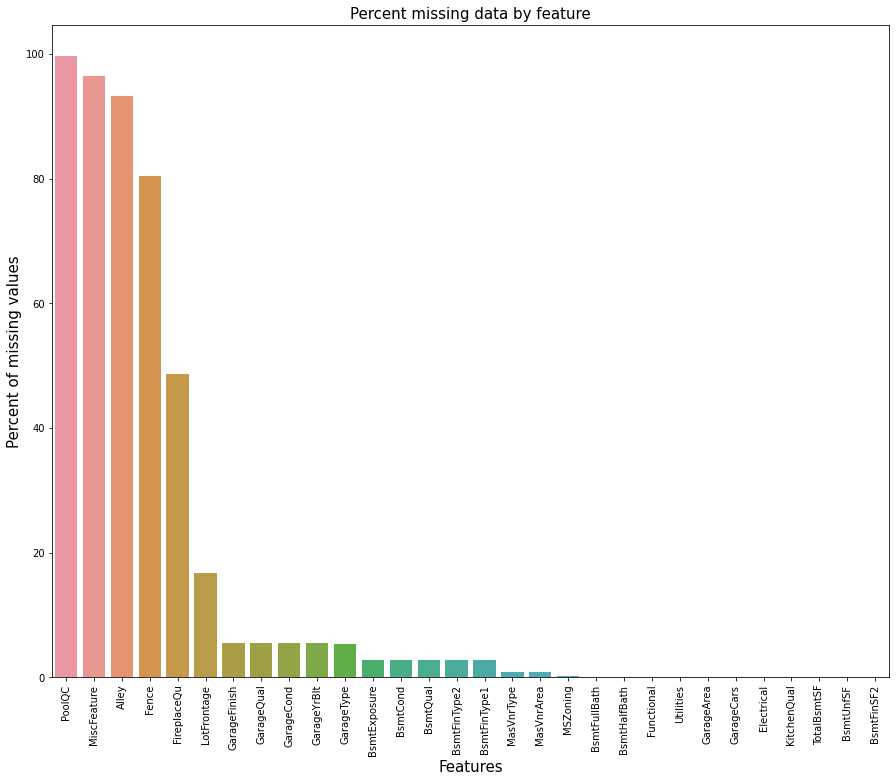

In [13]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

# 2.5 Replace_Missing Data

In [14]:
all_data_rep=all_data.copy()
all_data_rep["PoolQC"] = all_data_rep["PoolQC"].fillna(0)
all_data_rep["MiscFeature"] = all_data_rep["MiscFeature"].fillna(0)
all_data_rep["Fence"] = all_data_rep["Fence"].fillna(0)

all_data_rep["FireplaceQu"] = all_data_rep["FireplaceQu"].fillna(0)

all_data_rep["LotFrontage"] = all_data_rep.groupby('Neighborhood')["LotFrontage"].transform(
    lambda x:x.fillna(x.median()))

grd_col=["GarageQual","GarageCond","GarageType","GarageFinish","GarageArea","GarageCars","GarageYrBlt"]
for col in grd_col:
    all_data_rep[col] = all_data_rep[col].fillna(0)
    
grd_col=["BsmtExposure","BsmtCond","BsmtQual","BsmtFinType1","BsmtFinType2","BsmtUnfSF","BsmtFinSF1","BsmtFinSF2"]
for col in grd_col:
    all_data_rep[col] = all_data_rep[col].fillna(0)
    
all_data_rep["TotalBsmtSF"] = all_data_rep["TotalBsmtSF"].fillna(0)


all_data_rep["MasVnrArea"] = all_data_rep["MasVnrArea"].fillna(0)
all_data_rep["MasVnrType"] = all_data_rep["MasVnrType"].fillna(0)

all_data_rep['MSZoning']=all_data_rep['MSZoning'].fillna(all_data_rep['MSZoning'].mode()[0])

all_data_rep["BsmtFullBath"] = all_data_rep["BsmtFullBath"].fillna(0)
all_data_rep["BsmtHalfBath"] = all_data_rep["BsmtHalfBath"].fillna(0)



all_data_rep["Functional"] =all_data_rep["Functional"].fillna("Typ")

all_data_rep["Alley"] = all_data_rep["Alley"].fillna(0)

mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_col:
    all_data_rep[col] = all_data_rep[col].fillna(all_data_rep[col].mode()[0])

    
all_data_rep["MoSold"] = all_data_rep["MoSold"].fillna(0)

In [15]:
#Utilities still has null value, however we will drop this column later (it has only 1 value for majority-no result affect)
all_data_rep.isnull().sum().sort_values(ascending=False)[:3]

Utilities       2
MSSubClass      0
BedroomAbvGr    0
dtype: int64

# 2.6 New feature creation

In [16]:
all_data_rep['TotalSF'] = all_data_rep['TotalBsmtSF'] + all_data_rep['1stFlrSF'] + all_data_rep['2ndFlrSF']

In [17]:
all_data_rep_enc_1=all_data_rep.copy()

# 2.7 Categorical to Ordinal data
This step will help us to find some dependencies with categorical data, or some numerical will be encode in another more logical way

In [18]:
#MSSubClass will encode base on the SalePrice mean 
mean_sale_subclass=train.groupby(['MSSubClass']).mean()
df_mean_sale_subclass=pd.DataFrame(mean_sale_subclass['SalePrice'].sort_values(ascending=True)).reset_index()
df_mean_sale_subclass[:2]

,MSSubClass,SalePrice
0,30,95829.724638
1,180,102300.000000


In [19]:
subclass_order=list(df_mean_sale_subclass['MSSubClass'])
subclass_order

[30, 180, 45, 190, 90, 160, 50, 85, 40, 70, 80, 20, 75, 120, 60]

In [20]:
qual_map = {0: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

qual_col=['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond','ExterQual',
          'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual']
for col in qual_col:
    all_data_rep_enc_1[col] = all_data_rep_enc_1[col].map(qual_map)
#--------------------------------------------------------------
furnit_map = {0: 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ':6 }

furn_col=['BsmtFinType1', 'BsmtFinType2']
for col in furn_col:
    all_data_rep_enc_1[col] = all_data_rep_enc_1[col].map(furnit_map)

functional_map={0: 0, 'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2':6,'Min1': 7, 'Typ':8}
func_col=['Functional']
for col in func_col:
    all_data_rep_enc_1[col] = all_data_rep_enc_1[col].map(functional_map)

fence_map={0: 0, 'MnWw': 1, 'GdWo': 2, 'GdWo': 3, 'MnPrv': 4, 'GdPrv': 5}
fence_col=['Fence']
for col in fence_col:
    all_data_rep_enc_1[col] = all_data_rep_enc_1[col].map(fence_map)
    
bsm_exp_map={0: 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
all_data_rep_enc_1['BsmtExposure'] = all_data_rep_enc_1['BsmtExposure'].map(bsm_exp_map)

garag_fin_map={0: 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
all_data_rep_enc_1['GarageFinish'] = all_data_rep_enc_1['GarageFinish'].map(garag_fin_map)

slope_map={'Sev': 1, 'Mod': 2, 'Gtl': 3}
all_data_rep_enc_1['LandSlope'] = all_data_rep_enc_1['LandSlope'].map(slope_map)

shape_map={'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4}
all_data_rep_enc_1['LotShape'] = all_data_rep_enc_1['LotShape'].map(shape_map)

pave_map={'N': 1, 'P': 2, 'Y': 3}
all_data_rep_enc_1['PavedDrive'] = all_data_rep_enc_1['PavedDrive'].map(pave_map)

street_map={0:0,'Pave': 1, 'Grvl': 2}
all_data_rep_enc_1['Street'] = all_data_rep_enc_1['Street'].map(street_map)

alley_map={0: 0, 'Pave': 1, 'Grvl': 2}
all_data_rep_enc_1['Alley'] = all_data_rep_enc_1['Alley'].map(alley_map)

air_map={ 'N': 1, 'Y': 2}
all_data_rep_enc_1['CentralAir'] = all_data_rep_enc_1['CentralAir'].map(air_map)        

#1 value of MSSubClass(150) was not encoded,there is no SalePrice price for it, which we can use for analysis
#Let's take the same as 120

class_map={0:0,30:1, 180:2, 45:3, 190:4, 90:5, 160:6, 50:7, 85:8, 40:9, 70:10, 80:11, 20:12, 75:13, 120:14, 150:14, 60:15}
all_data_rep_enc_1['MSSubClass'] = all_data_rep_enc_1['MSSubClass'].map(class_map)

all_data_rep_enc_1['YrSold'].astype('int')

#all_data_rep_enc_1['MoSold'].astype('int')

mo_map={0:0, 4:1, 5:2, 6:7, 7:7.5, 8:9, 9:11, 10:2.5, 11:8.5, 2:8.5, 12:9.5, 1:1.5, 3:7.5}
all_data_rep_enc_1['MoSold'] = all_data_rep_enc_1['MoSold'].map(mo_map)

In [21]:
# Utilities we will drop later because it useless

all_data_rep_enc_1.isnull().sum().sort_values(ascending=False)[:3]

Utilities       2
MSSubClass      0
KitchenAbvGr    0
dtype: int64

# 3.Y-normality -log TRansform
According to Shapiro test, SalePrice is not normally distributed
The best way to fix it is to perform a log transform of the same data, with the intent to reduce the skewness.


 mu = 180932.92 and sigma = 79467.79



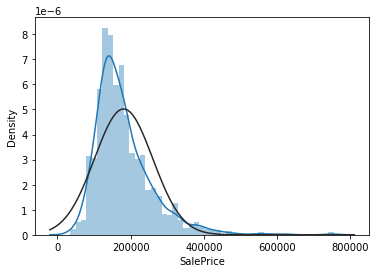

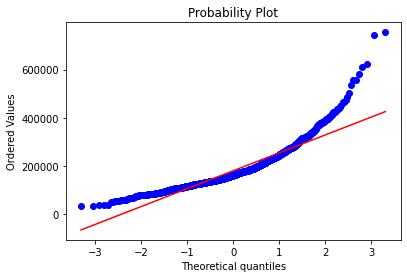

In [22]:
def check_skewness(col):
    sns.distplot(train[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(train[col], plot=plt)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(train[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
check_skewness('SalePrice')


 mu = 12.02 and sigma = 0.40



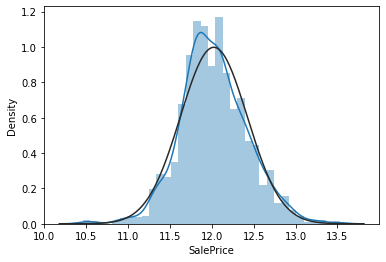

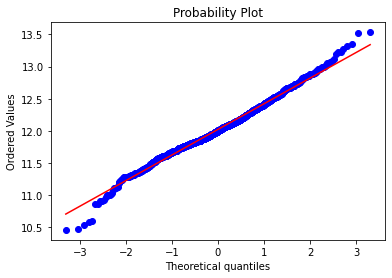

In [23]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

check_skewness('SalePrice')

In [24]:
y_train=train["SalePrice"]

# 4. X_log_transform

## Check skew for numerical value

In [25]:
all_data_rep_enc_1.dtypes[all_data_rep_enc_1.dtypes=='object'].index

Index(['MSZoning', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [26]:
numeric_feats = all_data_rep_enc_1.dtypes[all_data_rep_enc_1.dtypes!= "object"].index

# Check the skew of all numerical features
skewed_feats = all_data_rep_enc_1[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(3)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolQC,19.548879
PoolArea,17.688664


Box Cox Transformation of (highly) skewed features.

When you are dealing with real-world data, you are going to deal with features that are heavily skewed. Transformation technique is useful to stabilize variance, make the data more normal distribution-like, improve the validity of measures of association.

The problem with the Box-Cox Transformation is estimating lambda. This value will depend on the existing data, and should be considered when performing cross validation on out of sample datasets.

In [27]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.3
for feat in skewed_features:
    #all_data[feat] += 1
    all_data_rep_enc_1[feat] = boxcox1p(all_data_rep_enc_1[feat], lam)

There are 59 skewed numerical features to Box Cox transform


In [28]:
all_data_rep_enc_1.dtypes[all_data_rep_enc_1.dtypes== "object"].index


Index(['MSZoning', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [29]:
col_ob=list(all_data_rep_enc_1.dtypes[all_data_rep_enc_1.dtypes== "object"].index)
un=[]
for col in col_ob:
    n=all_data_rep_enc_1[col].nunique()
    un.append(n)

In [30]:
all_data_rep_enc_1_=all_data_rep_enc_1.copy()

# 5.Drop_befor_prediction

In [31]:
all_data_rep_enc_1=all_data_rep_enc_1_.drop(['Utilities'],axis=1)

# 6.Dummy encode for categorical values

In [32]:
all_data_dum = pd.get_dummies(all_data_rep_enc_1,drop_first=True)
all_data_dum.shape


(2917, 201)

In [33]:
X_train = all_data_dum[:ntrain]
x_test = all_data_dum[ntrain:]
X_train.shape

(1458, 201)

# 7. XGboost Algo

In [34]:
cv=KFold(n_splits=5,shuffle=True,random_state=241)

In [35]:
# Function to check score
def mse_cv(model):
    mse_my=np.sqrt(-cross_val_score(model,X=X_train,y=y_train,scoring="neg_mean_squared_error", cv = cv))
    return(mse_my.mean())

## 7.1 Basic model

Parameter n_estimators shows us - how many itterations we will go till the stop (stop to improve our score, stop to decrease our error). Too low n_estimators leads to model underfit,  too high n_estimators leads to model overfit. The best situation - a bit underfit in training dataset and minimum error in validation dataset.

In [36]:
model=XGBRegressor(objective='reg:squarederror',n_estimators=1000)
simp_model=mse_cv(model)
print('Score_simple_model',simp_model)

Score_simple_model 0.13163333371749322


## 7.2 Learning Rate tuning
Learning_rate is an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function. From each new tree we will multiply output by small number(=learning_rate), before adding them in. This will help to reduce overfit. So we can use high value of n_estimator without overfit. 
Early_stop_round - causes the model to stop iteration when the validation score stops to improve. Smart to set a high value for n_estimator, and then use early_stop_round to find optimum time to stop. In our exapmle after 5 rounds of score decreasing or standstill, itterations will be stopped.

In [69]:
lean_r=[0.0005,0.005,0.05,0.1,0.2]
final_score=[]

for lr in lean_r:
    model=XGBRegressor(objective='reg:squarederror',n_estimators=500, learning_rate=lr)
    impr_score_ln_rate=mse_cv(model)
    final_score.append(impr_score_ln_rate)

Text(0, 0.5, 'mse')

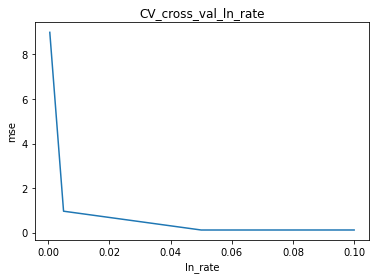

In [38]:
# Best ln_rate - 0.05
cv_boost_ln_rate = pd.Series(final_score[:4], index = lean_r[:4])
cv_boost_ln_rate.plot(title = "CV_cross_val_ln_rate")
plt.xlabel("ln_rate")
plt.ylabel("mse")

In [39]:
cv_boost =cv_boost_ln_rate

min_err=min(cv_boost.values)
impr_lr_rate=min_err



def get_key(cv_boost,min_err):
    for k,v in cv_boost.items():
        if v==min_err:
            return k,v
best_ln_rate=get_key(cv_boost,min_err)[0]
print('Impored_score_ln_rate',impr_lr_rate)
print('Best_ln_rate',best_ln_rate)

Impored_score_ln_rate 0.12146765528391609
Best_ln_rate 0.05


## 7.3 n_estimators tune


In [68]:
n_est=[500,600,700,750,1000]
learning_rate=best_ln_rate
final_score_n_est=[]

for n in n_est:
    model=XGBRegressor(objective='reg:squarederror',n_estimators=n,learning_rate=best_ln_rate)
    impr_score=mse_cv(model)
    final_score_n_est.append(impr_score)

Impored_score_n_est 0.12146765528391609


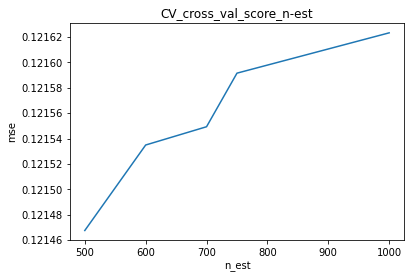

In [41]:
cv_boost_n_est = pd.Series(final_score_n_est, index = n_est)
impr_score_n_est=min(cv_boost_n_est.values)
cv_boost_n_est.plot(title = "CV_cross_val_score_n-est")
plt.xlabel("n_est")
plt.ylabel("mse")
print('Impored_score_n_est',impr_score_n_est)


## 7.4 Max_depth tune
It represents the depth of each tree, which is the maximum number of different features used in each tree. I recommend going from a low max_depth (3 for instance) and then increasing it incrementally by 1, and stopping when there’s no performance gain of increasing it. This will help simplify your model and avoid overfitting

In [42]:
max_d=[2,3,4,5,6]
final_score_max_d=[]

for m in max_d:
    model=XGBRegressor(objective='reg:squarederror',n_estimators=600, learning_rate=0.05, max_depth=m)
    impr_score=mse_cv(model)
    final_score_max_d.append(impr_score)

Text(0, 0.5, 'mse')

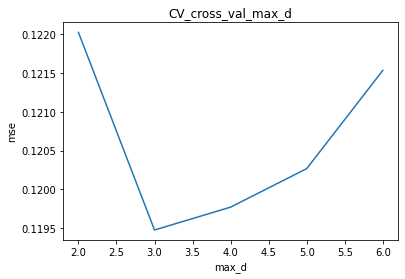

In [43]:
# best max_d=5
cv_boost_max_d = pd.Series(final_score_max_d, index = max_d)
cv_boost_max_d.plot(title = "CV_cross_val_max_d")
plt.xlabel("max_d")
plt.ylabel("mse")

In [44]:
model=XGBRegressor(objective='reg:squarederror',n_estimators=600, learning_rate=0.05,max_depth=5)
impr_score_3_par=mse_cv(model)

# 7.5 Min_child_weight tune
This parameter represent minimum amount of observation in the leaf. Help to prevent overfitting

In [45]:
min_child=[1,2,3,4,5]
final_score_min_child=[]

for m in min_child:
    model=XGBRegressor(objective='reg:squarederror',n_estimators=600, learning_rate=0.05, max_depth=5, min_child_weight=m)
    impr_score=mse_cv(model)
    final_score_min_child.append(impr_score)

In [46]:
cv_boost=pd.DataFrame((zip(min_child,final_score_min_child)), columns=['Child','Score']).sort_values(by='Score',ascending=True)
#cv_boost[:1]
impr_score_4_par=cv_boost[:1]['Score']
impr_min_child_weight=cv_boost[:1]['Child']

print('Score XGBoost improved ln_rate,n_est,max_depth,min_child',round(impr_score_4_par,5))
print('Best_min_child',round(impr_min_child_weight))

Score XGBoost improved ln_rate,n_est,max_depth,min_child 3    0.11846
Name: Score, dtype: float64
Best_min_child 3    4
Name: Child, dtype: int64


In [47]:
model=XGBRegressor(objective='reg:squarederror',n_estimators=600, learning_rate=0.05,max_depth=5, min_child_weight=3)
impr_score_4_par=mse_cv(model)

# 7.6 Subsample parameter tune
This parameter defines the share of data to be taken for each tree building. Usually takes value 0.5-1

In [48]:
subsample=[1,0.8,0.7,0.6,0.5]
final_score_subsample=[]

for m in subsample:
    model=XGBRegressor(objective='reg:squarederror',n_estimators=600, learning_rate=0.05, max_depth=5, min_child_weight=3,subsample=m)
    impr_score=mse_cv(model)
    final_score_subsample.append(impr_score)

In [49]:
cv_boost=pd.DataFrame((zip(subsample,final_score_subsample)), columns=['SubSam','Score']).sort_values(by='Score',ascending=True)
#cv_boost[:1]
impr_score_5_par=cv_boost[:1]['Score']
impr_min_subsample=cv_boost[:1]['SubSam']

print('Score XGBoost improved ln_rate,n_est,max_depth,min_child,subsample',round(impr_score_5_par,5))
print('Best_subsample',impr_min_subsample)

Score XGBoost improved ln_rate,n_est,max_depth,min_child,subsample 3    0.11674
Name: Score, dtype: float64
Best_subsample 3    0.6
Name: SubSam, dtype: float64


In [50]:
model=XGBRegressor(objective='reg:squarederror',n_estimators=600, learning_rate=0.05,max_depth=5, min_child_weight=3,subsample=0.5)
impr_score_5_par=mse_cv(model)

### Improved Score XGBoost

In [51]:
print('Score XGBoost improved ln_rate,n_est,max_depth,min_child,subs',round(impr_score_5_par,5))
print('Score XGBoost impln_rate,n_est,max_dep,min_chi',round(impr_score_4_par,5))
print('Score XGBoost improved ln_rate,n_est,max_depth',round(impr_score_3_par,5))
print('Score XGBoost improved ln_rate,n_est          ',round(impr_score_n_est,5))
print('Score XGBoost improved ln_rate                ',round(impr_lr_rate,5))
print('Score XGBoost simple_model                    ',round(simp_model,5))

Score XGBoost improved ln_rate,n_est,max_depth,min_child,subs 0.11707
Score XGBoost impln_rate,n_est,max_dep,min_chi 0.11863
Score XGBoost improved ln_rate,n_est,max_depth 0.12027
Score XGBoost improved ln_rate,n_est           0.12147
Score XGBoost improved ln_rate                 0.12147
Score XGBoost simple_model                     0.13163


## 7.7 GridSearch Parameters tune
As well we can use GridSearchCV for parameters tuning. We have different scores and different best parameters in cross-validation and GridSearchCV.
Why is it so? The difference may be due to that the cross-validation
splits used in cross_validate and GridSearchCV are different, due to the randomness. The effect of this randomness becomes even larger as your dataset is very small and the number of folds
is large. A possible fix is to feed into cv a fix train/test splits, 
and reduce the number of folds to reduce the variance.



Lets check score with parameters that we defined with GridSearchCV (in parallel kernel, to save our time)

In [52]:
model_param_grid= XGBRegressor(objective='reg:squarederror',subsample=0.6,n_estimators=1400,learning_rate=0.03,max_depth=3,min_child_weight=3)

In [53]:
impr_score_grid=mse_cv(model_param_grid)
print('Score XGBoost improved GridSearchCV',round(impr_score_grid,5))

Score XGBoost improved GridSearchCV 0.11592


# 7.8 Feature Selection score tune
Not all features equally important. We already saw it correlation chapter, that some influence more then another. Here we will check feature importance and will improve score by refusing from useless features.

In [54]:
model = XGBRegressor(objective='reg:squarederror',learning_rate=0.03,n_estimators=1400,max_depth=3,min_child_weight=3,subsample=0.6)
model.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=1400, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
importance = model.feature_importances_
feat_impot=pd.DataFrame((zip(X_train.columns, importance)), columns=['Feat','Importance']).sort_values(by='Importance',ascending=False)
feat_impot

,Feat,Importance
42,GarageCars,0.087791
39,FireplaceQu,0.064719
14,BsmtQual,0.060625
58,TotalSF,0.057404
12,ExterQual,0.056904
...,...,...
130,RoofMatl_WdShngl,0.000000
127,RoofMatl_Roll,0.000000
126,RoofMatl_Metal,0.000000
125,RoofMatl_Membran,0.000000


In [56]:
def mse_cv_1(model,X):
    mse_my=np.sqrt(-cross_val_score(model,X=X,y=y_train,scoring="neg_mean_squared_error", cv = cv))
    return(mse_my.mean())

In [57]:
feat=[120,130,140,201]
score_feat=[]
for f in feat:
    feat_best=feat_impot['Feat'][:f]
    feat_best_list=list(feat_best)
    X_feat=X_train[feat_best_list]
    score_feat.append(mse_cv_1(model,X_feat))

In [58]:
score_feat

[0.11535726069594185,
 0.11500094510939114,
 0.1161140748077721,
 0.1153137669407986]

#### Score with Feature Selection

In [59]:
feat_best=feat_impot['Feat'][:130]
feat_best_list=list(feat_best)
X_feat=X_train[feat_best_list]

In [60]:
model_feat_sel=XGBRegressor(objective='reg:squarederror',learning_rate=0.03,n_estimators=1400,max_depth=3,min_child_weight=3,subsample=0.6)
impr_score_feat_sel=mse_cv_1(model,X_feat)

In [61]:
print('Score XGBoost improved GridSearchCV feat selection_130 ',round(impr_score_feat_sel,5))

Score XGBoost improved GridSearchCV feat selection_130  0.115


 # 8.GradientBoosting model

To compare XGBoost scores we will GradientBoostingRegressor


In [62]:
from sklearn.ensemble import GradientBoostingRegressor
model_boost=GradientBoostingRegressor()
score_boost=mse_cv(model_boost)
print('Score_GradBoost',score_boost)

Score_GradBoost 0.12620021011668936


# 9.Conclusion
In this kernel we familiar XGBoostRegression, defined main hyperparametes of this model and imroved a bit our model by parameters` tuning. Final result is far from the top, however this work was created for XGBoost basic understanding.

In [63]:
print('Score XGBoost improved GridSearchCV feat selection_130       ',round(impr_score_feat_sel,5))
print('Score XGBoost improved GridSearchCV                          ',round(impr_score_grid,5))
print('Score XGBoost improved ln_rate,n_est,max_depth,min_child,subs',round(impr_score_5_par,5))
print('Score XGBoost impln_rate,n_est,max_dep,min_chi               ',round(impr_score_4_par,5))
print('Score XGBoost improved ln_rate,n_est,max_depth',round(impr_score_3_par,5))
print('Score XGBoost improved ln_rate,n_est          ',round(impr_score_n_est,5))
print('Score XGBoost improved ln_rate                ',round(impr_lr_rate,5))
print('Score XGBoost improved simple_model           ',round(simp_model,5))
print('Score GradientBoost                           ',round(score_boost,5))

Score XGBoost improved GridSearchCV feat selection_130        0.115
Score XGBoost improved GridSearchCV                           0.11592
Score XGBoost improved ln_rate,n_est,max_depth,min_child,subs 0.11707
Score XGBoost impln_rate,n_est,max_dep,min_chi                0.11863
Score XGBoost improved ln_rate,n_est,max_depth 0.12027
Score XGBoost improved ln_rate,n_est           0.12147
Score XGBoost improved ln_rate                 0.12147
Score XGBoost improved simple_model            0.13163
Score GradientBoost                            0.1262


In [64]:

model=XGBRegressor(objective='reg:squarederror',learning_rate=0.03,n_estimators=1400,
                   max_depth=3,min_child_weight=3,subsample=0.6)
X_train_feat=X_train[feat_best_list]
x_test_feat=x_test[feat_best_list]

XGB=model.fit(X_train_feat,y_train)

test=x_test_feat.copy()

finalMd = np.expm1(XGB.predict(test))

finalMd


array([124876.48 , 164889.94 , 192944.34 , ..., 164415.72 , 110825.875,
       210674.8  ], dtype=float32)

In [70]:

sample_submission = pd.read_csv("./Data/sample_submission.csv")
sample_submission.iloc[:,1] = finalMd
sample_submission.to_csv("sample_submission.csv", index=False)